In [1]:
# Imports
import numpy as np
import torch

from phimal_utilities.analysis import load_tensorboard
from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from sklearn.linear_model import LassoLarsIC

import time
from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss, l1_loss
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling, threshold
from numpy import pi

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Settings and parameters
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Making data

In [2]:
v = 0.1
A = 1.0

# Making grid
x = np.linspace(-3, 4, 80)
t = np.linspace(0.5, 5.0, 25)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

# Making data
dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.1, random=False)

theta = dataset.library(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), poly_order=2, deriv_order=2)
dt = dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))


# Running non-differentiable

In [3]:
def train(model, data, target, optimizer, max_iterations, loss_func_args):
    '''Trains the deepmod model with MSE, regression and l1 cost function. Updates model in-place.'''
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    board = Tensorboard(number_of_terms)
    
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        with torch.no_grad():
            t = theta.detach()
            dt = time_deriv_list[0].detach()
            coeff_vector_list = [torch.inverse(t.T @ t) @ (t.T @ dt)] # normal equation for least squares
            
        loss_mse = mse_loss(prediction, target)
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss = torch.sum(2 * torch.log(2 * pi * loss_mse) + loss_reg / loss_mse) 
        
        # Writing
        if iteration % 100 == 0:
            # Write progress to command line
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_reg).item())
            
            # Calculate error for theta
            theta_true = loss_func_args['library']
            dt_true = loss_func_args['time_deriv']
            mae_library = torch.mean(torch.abs(theta - theta_true), dim=0)
            mae_dt = torch.mean(torch.abs(dt_true - time_deriv_list[0]), dim=0)
            
            # Write to tensorboard
            board.write(iteration, loss, loss_mse, loss_reg, loss_reg, coeff_vector_list, coeff_vector_scaled_list, mae_library=mae_library, mae_time_deriv=mae_dt)

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    board.close()

In [4]:
# Running deepmod
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'sparsity_estimator': LassoLarsIC(fit_intercept=False)}
model = DeepModDynamic(**config)
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [5]:
train(model, X_train, y_train, optimizer, 10000, loss_func_args={'library':torch.tensor(theta) ,'time_deriv': torch.tensor(dt)})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
      10000    100.00%               0s   -1.22e+01   3.49e-04   2.83e-06   2.83e-06 

# Differentiable version

In [6]:
def train(model, data, target, optimizer, max_iterations, loss_func_args):
    '''Trains the deepmod model with MSE, regression and l1 cost function. Updates model in-place.'''
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    board = Tensorboard(number_of_terms)
    
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_mse = mse_loss(prediction, target)
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss = torch.sum(2 * torch.log(2 * pi * loss_mse) + loss_reg / loss_mse) 
        
        # Writing
        if iteration % 100 == 0:
            # Write progress to command line
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_reg).item())
            
            # Calculate error for theta
            theta_true = loss_func_args['library']
            dt_true = loss_func_args['time_deriv']
            mae_library = torch.mean(torch.abs(theta - theta_true), dim=0)
            mae_dt = torch.mean(torch.abs(dt_true - time_deriv_list[0]), dim=0)
            
            # Write to tensorboard
            board.write(iteration, loss, loss_mse, loss_reg, loss_reg, coeff_vector_list, coeff_vector_scaled_list, mae_library=mae_library, mae_time_deriv=mae_dt)

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    board.close()
    

In [7]:
# Running deepmod
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'sparsity_estimator': LassoLarsIC(fit_intercept=False)}
model = DeepModDynamic(**config)
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [8]:
train(model, X_train, y_train, optimizer, 10000, loss_func_args={'library':torch.tensor(theta) ,'time_deriv': torch.tensor(dt)})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
      10000    100.00%               0s   -1.22e+01   3.49e-04   3.10e-06   3.10e-06 

# Comparing

In [9]:
df_differentiable = load_tensorboard('runs/differentiable/')
df_nondifferentiable = load_tensorboard('runs/non_differentiable/')

In [10]:
df_differentiable.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'scaled_coeff_0_0', 'scaled_coeff_0_1',
       'scaled_coeff_0_2', 'scaled_coeff_0_3', 'scaled_coeff_0_4',
       'scaled_coeff_0_5', 'scaled_coeff_0_6', 'scaled_coeff_0_7',
       'scaled_coeff_0_8', 'mae_library_0', 'mae_library_1', 'mae_library_2',
       'mae_library_3', 'mae_library_4', 'mae_library_5', 'mae_library_6',
       'mae_library_7', 'mae_library_8', 'mae_time_deriv'],
      dtype='object')

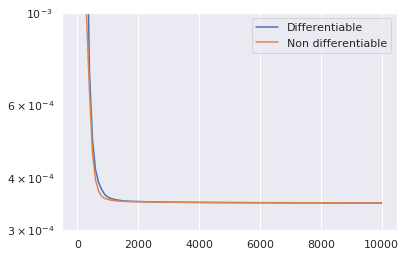

In [15]:
plt.semilogy(df_differentiable.index, df_differentiable['MSE_0'], label='Differentiable')
plt.semilogy(df_nondifferentiable.index, df_nondifferentiable['MSE_0'], label='Non differentiable')

plt.ylim([3e-4, 1e-3])
plt.legend()

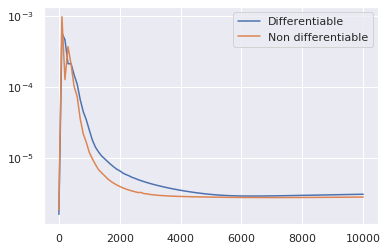

In [16]:
plt.semilogy(df_differentiable.index, df_differentiable['Regression_0'], label='Differentiable')
plt.semilogy(df_nondifferentiable.index, df_nondifferentiable['Regression_0'], label='Non differentiable')

#plt.ylim([3e-4, 1e-3])
plt.legend()

In [24]:
coeff_keys = [key for key in df_differentiable.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df_differentiable.keys() if key[:6]=='scaled'] 

(-1.5, 0.5)

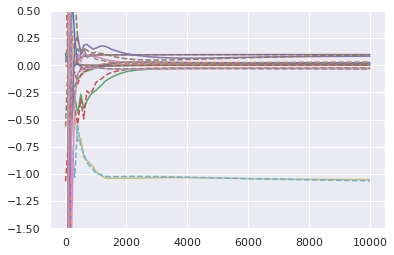

In [23]:
for key in coeff_keys:
    plt.plot(df_differentiable[key], label=f'{key[-1]}')
    plt.plot(df_nondifferentiable[key], '--',label=f'{key[-1]}')
#plt.legend()
plt.ylim([-1.5, 0.5])

(-1.2, 0.25)

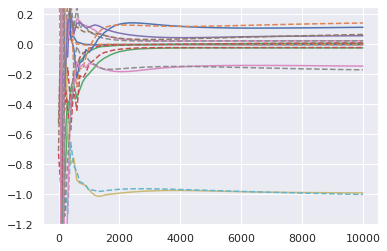

In [27]:
for key in scaled_coeff_keys:
    plt.plot(df_differentiable[key], label=f'{key[-1]}')
    plt.plot(df_nondifferentiable[key], '--',label=f'{key[-1]}')
#plt.legend()
plt.ylim([-1.2, 0.25])

In [28]:
library_terms = [key for key in df_differentiable.keys() if key[:11] == 'mae_library']

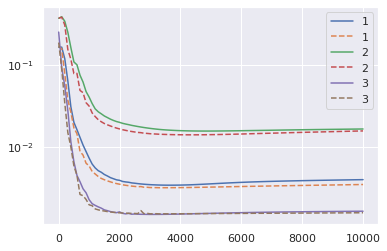

In [31]:
for key in library_terms[1:4]:
    plt.semilogy(df_differentiable[key], label=f'{key[-1]}')
    plt.semilogy(df_nondifferentiable[key], '--',label=f'{key[-1]}')
plt.legend()

In [38]:
mae_diff = [df_differentiable['mae_time_deriv'].to_numpy()[:, None]]
for key in library_terms[1:4]:
    mae_diff.append(df_differentiable[key].to_numpy()[:, None])
mae_diff = np.concatenate(mae_diff, axis=1)

In [43]:
mae_nondiff = [df_nondifferentiable['mae_time_deriv'].to_numpy()[:, None]]
for key in library_terms[1:4]:
    mae_nondiff.append(df_nondifferentiable[key].to_numpy()[:, None])
mae_nondiff = np.concatenate(mae_nondiff, axis=1)

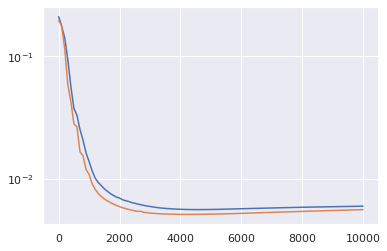

In [44]:
plt.semilogy(df_differentiable.index, np.mean(mae_diff, axis=1))
plt.semilogy(df_nondifferentiable.index, np.mean(mae_nondiff, axis=1))

In [45]:
true_coeffs = np.zeros((1, 9))
true_coeffs[0, 2] = 0.1
true_coeffs[0, 4] = -1.0

In [46]:
mae_coeff_diff = []

for key in coeff_keys:
    mae_coeff_diff.append(df_differentiable[key].to_numpy()[:, None])
mae_coeff_diff = np.concatenate(mae_coeff_diff, axis=1)


mae_coeff_diff = np.abs(mae_coeff_diff - true_coeffs)

In [47]:
mae_coeff_nondiff = []

for key in coeff_keys:
    mae_coeff_nondiff.append(df_nondifferentiable[key].to_numpy()[:, None])
mae_coeff_nondiff = np.concatenate(mae_coeff_nondiff, axis=1)


mae_coeff_nondiff = np.abs(mae_coeff_nondiff - true_coeffs)

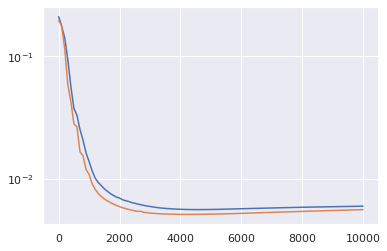

In [49]:
plt.semilogy(df_differentiable.index, np.mean(mae_diff, axis=1), label='MAE coeffs')
plt.semilogy(df_nondifferentiable.index, np.mean(mae_nondiff, axis=1), label='MAE library')

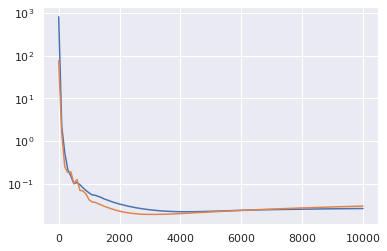

In [50]:
plt.semilogy(df_differentiable.index, np.mean(mae_coeff_diff, axis=1), label='MAE coeffs')
plt.semilogy(df_nondifferentiable.index, np.mean(mae_coeff_nondiff, axis=1), label='MAE library')

So conclusion is; no big difference between differentiable and non-differentiable?
